<h1><center>Gesture Kinematic Spaces with Dynamic Time Warping (shapeDTW) </center></h1>
<h3><center>contact: wim.pouw@donders.ru.nl</center></h3>

![](./images/envision_banner.png)

## Info documents

* location Repository: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/gesture_kinematic

* location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/blob/main/MultimodalMerging/gesture_kinematic_spaces.ipynb

### Citation
Pouw, W. (2024). Wim Pouw's EnvisionBOX modules for social signal processing (Version 1.0.0) [Computer software]. https://github.com/WimPouw/envisionBOX_modulesWP

## Background
Human (communicative) body movements are often recurrent, such that they use similar shapes or trajectories to convey or act on something consistently. How can we make sense of the variability and consistency with which movement events are produced? How can determine that two gestures are more or less similar in form? One way to do this is by quantifying the similarities present between all the produced movement events. Once we have documented how similar each movement event is relative to all other events, we can then visualize and quantify the structure of these interrelationships and discover novel patterns that exist over the entire set of behaviors. Furthermore, we can make an informed decision of what gestures are highly similar to each other relative to others. In previous work we have found that when communicative silent gestures have been practiced and communicated more, those silent gestures start to change their interrelationships in consistent ways (e.g., the kinematic space reduces in complexity) (see [3] Pouw, Dingemanse, Motamedi, Ozyurek, 2021).

Note that this particular procedure outlined here, is introduced in [1] Pouw & Dixon (2020) and we advise you to read this first before starting (or [3]). The main procedure: we compute some distance measure between two N-dimenionsal time series *i* and *j*, and do this for all events *n*. Similar to previous work [1] we will use dynamic time warping (see [2] Giorgino, 2009) as the distance calculation. We then compute what is called a distance matrix (**M**) which has *n* rows and *n* columns containing for each cell M[*i*,*j*] the distance score between movement *i* and *j*. Then we can use dimensional reduction techniques (e.g., classic multidimenionsal scaling, t-sne, UMAP, PCA) to visualize in 2-dimensional space the interrelationships between all movement events.

For the current movement events we use a set of silent gestures produced by an actor conveying certain concepts (open dataset by: [4][Ortega & Ozyurek, 2020). We extracted the movement information using mediapipe 3D body tracking for each silent gesture, and this is the input of our procedure. Note that the current procedure can be applied on any signal (e.g., acoustic trajectories) and also on multiple persons that are producing movement events.


## Overview processing steps

This markdown file contains the following processing steps.

* Create a distance matrix with dynamic time warping distances between events

* Perform dimensionality reduction to get a 2D space representing the interrelationships (which will be used to build an app as shown [here](https://envisionbox.org/embedded_dynamicvisualizer.html).

* Create a gesture network, and extract some features to relate to the metadata of Ortega et al.

# Starting up
Lets load some general packages, identify the right folders and show some of the data we are working with.

In [1]:
# loading in some basic packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import matplotlib.pyplot as plt              # for plotting
import plotly.graph_objects as go            # for plotting
import html                                  # for html-related add-ons
import os                                    # for foldering                              
from IPython.display import Video           # for displaying videos
from scipy.ndimage import gaussian_filter1d  # for smoothing

# initializing some folders and files
timeseriesfolder = "../TimeSeries/"
distancematrixfolder = "../Distance_matrices/"
videofolder = "../Videos/WithMotionTracking/"

# lets loop through all motion tracking files and print any files that have more than 50% NaN values, or have shorter than 10 frames
# consider removing these files
for filename in os.listdir(timeseriesfolder):
    # read in the file
    data = pd.read_csv(timeseriesfolder + filename)
    
    # check if there are more than 50% NaN values
    if data.isna().sum().sum() > 0.5 * data.shape[0] * data.shape[1]:
        print("A lot of NAS!: " + filename)
    # check if there are less than 20 frames
    if data.shape[0] < 10:
        print("short gestures:" + filename)

The folder 'TimeSeries' is filled with mediapipe body tracking time series for each video. We extract from it, nose, elbow, index finger (x , y, z) info (for both hands). Figure 1 shows an example of the kinematic time series for the silent gesture "TO-SWIM" which is also shown below. The swimming gesture has a characteristic rhythmic movement, as reflected in the oscillating movements in the horizontal dimension for left and right index finger. 





Figure 1. Example raw time series of SWIMMING for the right (red) and left hand (in blue)

we will load in the following gesture:  ../TimeSeries\03_example.mp4_segment_10_Gesture_33.68_34.84_body.csv


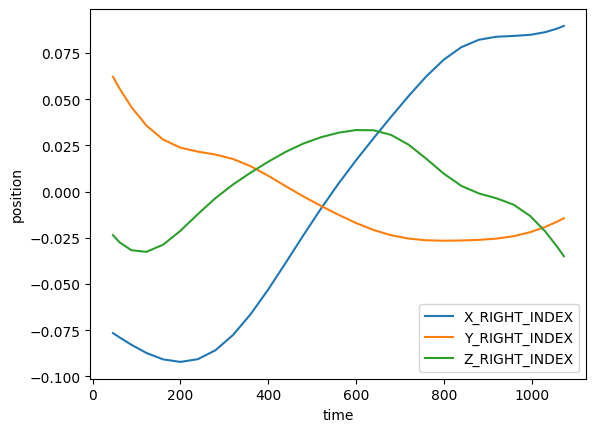

we will show the following video:  ../Videos/WithMotionTracking/TimeSeries\03_example.mp4_segment_10_Gesture_33.68_34.84_body.mp4


In [2]:
import glob as glob
import moviepy as mpy

#load in data
gestures = glob.glob(timeseriesfolder+"*.csv") # select one
gestureselected = gestures[0]
print("we will load in the following gesture: ", gestureselected)
MT = pd.read_csv(gestureselected)
MT = MT.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little
# center the data
MT['X_RIGHT_INDEX'] = MT['X_RIGHT_INDEX'] - MT['X_RIGHT_INDEX'].mean()
MT['Y_RIGHT_INDEX'] = MT['Y_RIGHT_INDEX'] - MT['Y_RIGHT_INDEX'].mean()
MT['Z_RIGHT_INDEX'] = MT['Z_RIGHT_INDEX'] - MT['Z_RIGHT_INDEX'].mean()
#plot X_RIGHT_INDEX and Y_RIGHT_INDEX time series with time as x-axis
plt.plot(MT['time'], MT['X_RIGHT_INDEX'], label='X_RIGHT_INDEX')
plt.plot(MT['time'], MT['Y_RIGHT_INDEX'], label='Y_RIGHT_INDEX')
plt.plot(MT['time'], MT['Z_RIGHT_INDEX'], label='Z_RIGHT_INDEX')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show()

# show the video whichever has the best match
videofile = videofolder + gestureselected.split("/")[-1].replace(".csv", ".mp4")
print("we will show the following video: ", videofile)


# DTW

## DTW basics
Dynamic time warping is a method to compare and match two sequences (often time series). It tries to match sequences by allowing for some non-linear distortions in time (or another dimension), so that sequences maximally line up, so as to determine their similarity (after some distortion). This distortation has certain limits and constraints (e.g., such that values matched are not cris-crossing in time) and the degree of time distortions are effectively visualized by a warping path shown below. After matching values in one sequence to another value in the other sequence, one can compute the difference (e.g., euclidean distance between the values) that is still left between these warped sequences. This difference, error, or hereonafter "distance", provides a measure of dissimilarity between two time series. Note dynamic time warping can also compute distances between time series that have more than 1 dimension (as exemplified below). The dynamic time warping distances are best expressed after normalization when time series are known to have unequal lengths (otherwise, distances would add to bigger numbers for longer time series, than shorter one's, though they might be equally similar). The normalization consist in dividing the distance by the length of the timeseries.

## Shape DTW
There are now various variants of DTW. We are using "shape dtw" for this example, which was developed to overcome certain issues with 'classic DTW' having to do with matching segments between timeseries that should not be matched as they are actually quite dissimilar. The inventors of shapeDTW state "Shape-DTW is inherently a DTW algorithm,but additionally attempts to pair locally similar structures and to avoid matching points with distinct neighborhoodstructures", p. 1, for the original paper see [https://arxiv.org/pdf/1606.01601.pdf](here). For a nice introduction with how to set up your DTW pipeline, see here [https://mikolajszafraniecupds.github.io/shapedtw-python/](https://mikolajszafraniecupds.github.io/shapedtw-python/). Shape dtw operates on subsequences of the time series so that it can take into account not only a single point that needs to be matched with the another point in the sequence, but rather take into account the context of the neighboring points too. It therefore favours point that have a similar surrounding values, rather than just single points that have matching values. We set the width of the context at 20 (i.e., 20 timesteps, context of about 800ms assuming a framerate of 25fps), as this seems to provide good matches.

# Other things to consider
There are many other different things that you need to consider when doing dynamic time warping. For example, you if you care about the general shape of a gesture but not its size, then you might want to normalize (e.g., z-scale) the time series first. Or you might not care about the place in gesture space, so you center the the position coordinates first. Also consider, we now only take a few keypoints that might not capture enough of the hand shape or other features, so you can consider adding more keypoints (a the cost of computational time). 

Further, what if you have a gesture consisting of multiple elements, and you want to judge another gesture as similar when it has the same elements regardless of the order of the items? Then you might not want to use dynamic time warping as it will judge a time series with elements a-b-c to be completely different from a time series with elements c-b-a (a possible time series distance measure that does judge such time series to be similar is matrix profile distance or MPdist). 

There are also a range of settings that optimize dynamic time warping performance. For example, you may want to limit the distance error calculation to be based on the begin and trailing portions of the time series as these often are difficult to match, which can be a pesky issue in classic-dtw discussed in [4] (Silva et al 2016; a possible solution for this is psy-dtw). Or it might happen that the warping leads to extreme distortions in time leading to non-sensical matches (a solution for this is limiting the maximum warping constraint, using for example a Sakoe-Chiba window). There are many such optimizations and it would be good to familiarize oneself with these as they can greatly improve performance.

# Further study
This module barely scratches the surface of what is behind dynamic time warping. A nice more in-depth covering of DTW is overviewed here https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S2_DTWbasic.html, with an open access book chapter https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S2_DTWbasic.html. Then we would recommend digging further into the specific implimentation used here, which is shape-dtw: https://mikolajszafraniecupds.github.io/shapedtw-python/.

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



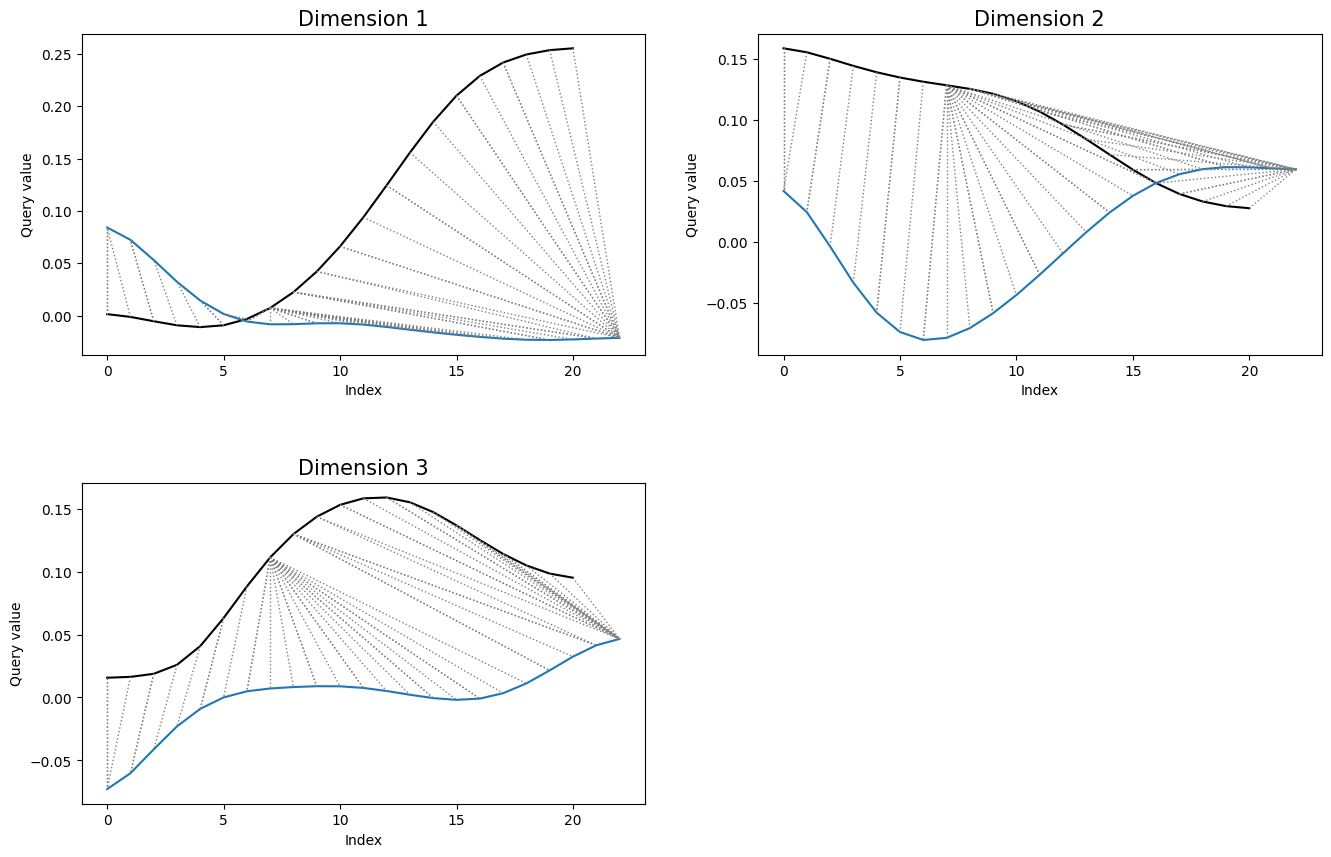

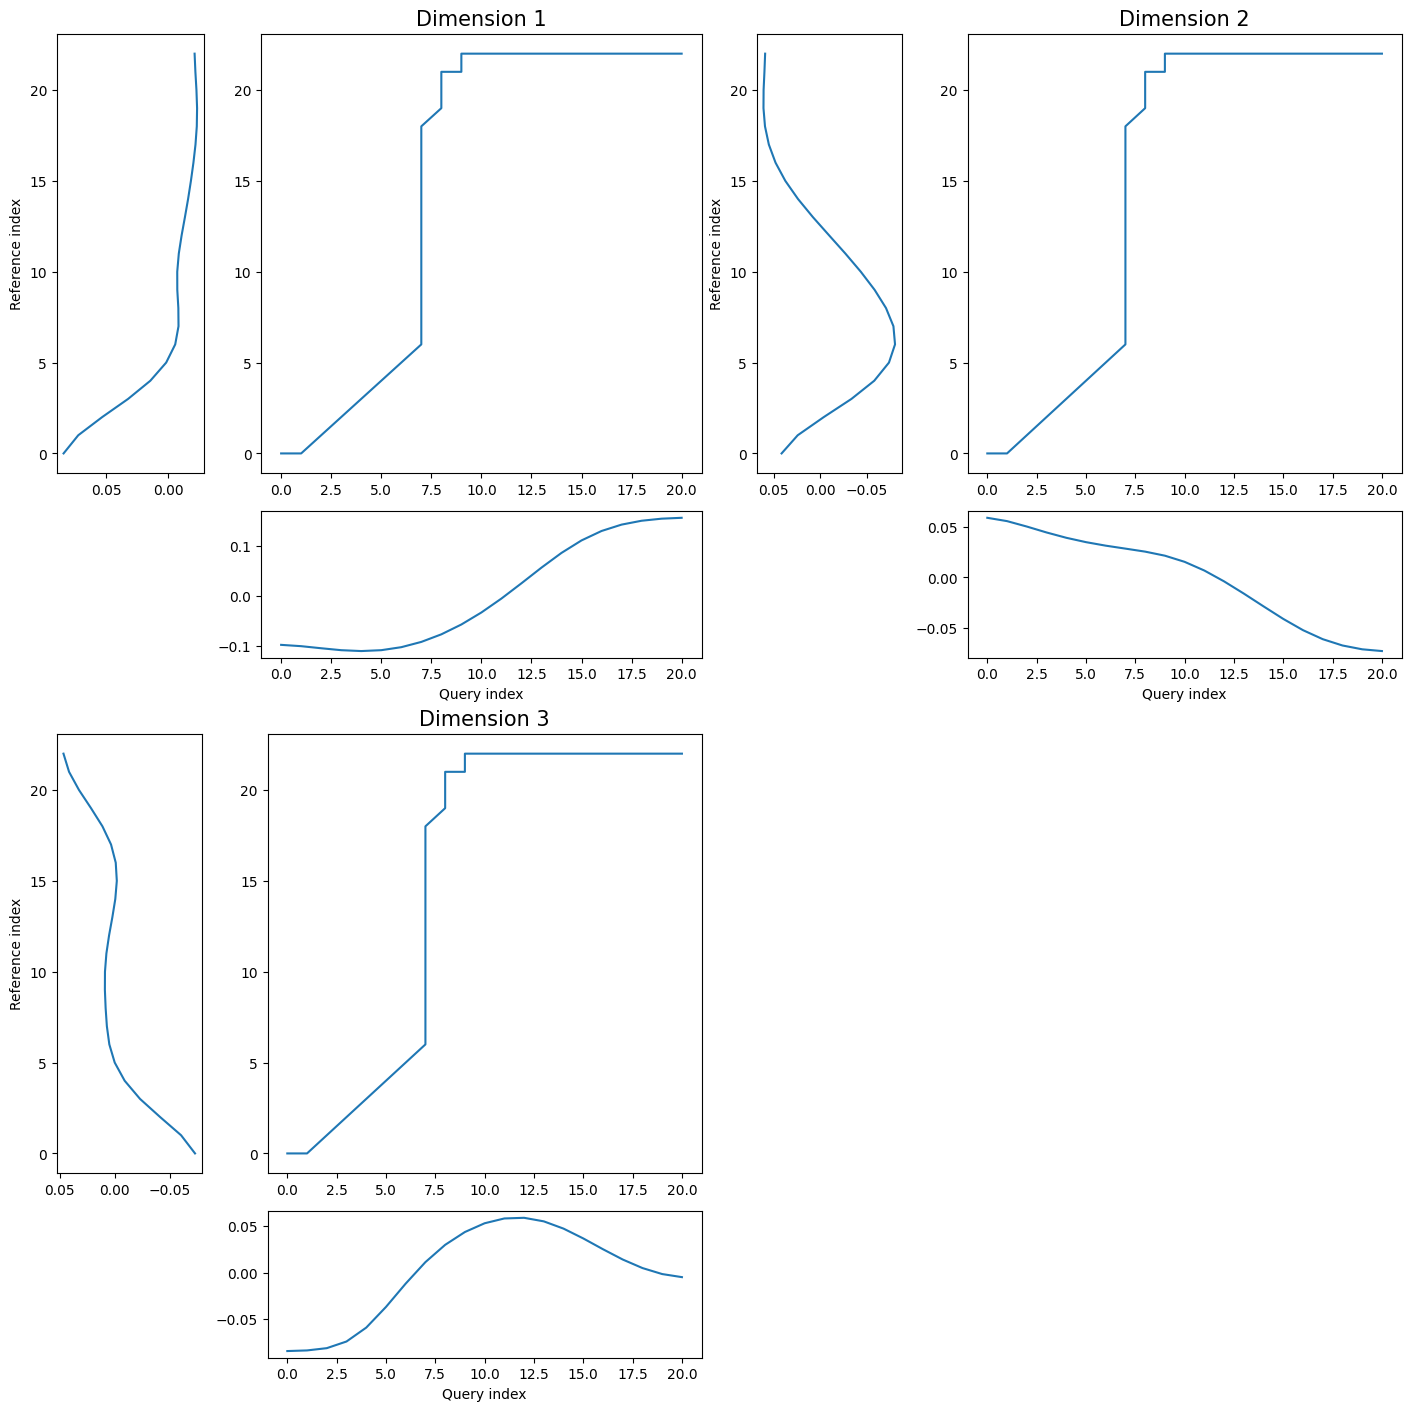

DTW distance is: 5.48
Normalized DTW distance is: 0.12451554742087062


In [3]:
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import RawSubsequenceDescriptor

# using dtw to compare distances and show a warping line
gestures = glob.glob(timeseriesfolder+"*_body.csv") # select one
gestureselect1 = gestures[11]
gestureselect2 = gestures[12]
MT1 = pd.read_csv(gestureselect1)
MT2 = pd.read_csv(gestureselect2) #compare example against BANANA
MT1 = MT1.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little
MT2 = MT2.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little

# select some set of features from the motion tracking dataframe
keypointindexleft = ["X_RIGHT_INDEX", "Y_RIGHT_INDEX", "Z_RIGHT_INDEX"]
ts1 = np.array(MT1[keypointindexleft]-MT1[keypointindexleft].mean())
ts2 = np.array(MT2[keypointindexleft]-MT2[keypointindexleft].mean())

# setting up the DTW functions
shape_dtw_dependent_results = shape_dtw(
    x=ts1,
    y=ts2,
    subsequence_width=5, # so this means for the matching that we take x indices into account
    shape_descriptor=RawSubsequenceDescriptor(), # the local context that is taken to compare to other local context is just the raw values
    multivariate_version="dependent" 
)
dependent_distance = round(shape_dtw_dependent_results.distance, 2)
dependent_distance_normalized = shape_dtw_dependent_results.normalized_distance
dtwPlot(shape_dtw_dependent_results, plot_type="twoway", xoffset=0.1)
dtwPlot(shape_dtw_dependent_results, plot_type="threeway")

print("DTW distance is: " + str(dependent_distance))
print("Normalized DTW distance is: " + str(dependent_distance_normalized))


## Main routine: constructing a distance matrix

The next step is to compute a average dynamic time warping distance between joint position traces. This means we are performing a dependent DTW (using fast-dtw), where x,y,z time series are submitted for DTW comparison for a gesture *i* and gesture event *j*, and we perform this procedure for each joint separately (this averaging of by-keypoint DTW comparisons is called an independent DTW; so we are combining an independent and dependent DTW version). 

In [4]:
#identify which column indices in a dataframe correspond to which body parts
keypointindexright =  ["X_RIGHT_INDEX", "Y_RIGHT_INDEX", "Z_RIGHT_INDEX"]
keypointindexleft = ["X_LEFT_INDEX", "Y_LEFT_INDEX", "Z_LEFT_INDEX"]
keypointelbowright = ["X_RIGHT_ELBOW", "Y_RIGHT_ELBOW", "Z_RIGHT_ELBOW"]
keypointelbowleft = ["X_LEFT_ELBOW", "Y_LEFT_ELBOW", "Z_LEFT_ELBOW"]
keypointshoulderright = ["X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER"]
keypointshoulderleft = ["X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER"]

# make one 1 list with all keypoints
keypoints = keypointindexright + keypointindexleft + keypointelbowright + keypointelbowleft + keypointshoulderright + keypointshoulderleft

#make a function that takes in two timeseries and produces a normalized dtw distance
def dtw_distance(ts1, ts2):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)
    res = shape_dtw(x = ts1, y = ts2, subsequence_width=5,shape_descriptor=RawSubsequenceDescriptor(), multivariate_version="dependent")
    distance = res.normalized_distance
    return distance

# make a dependent dtw such that each keypoint dtw distance is added up
def dtw_distance_dependent(MT1, MT2):
    disleftindex = dtw_distance(MT1[keypointindexleft], MT2[keypointindexleft])
    disrightindex = dtw_distance(MT1[keypointindexright], MT2[keypointindexright])
    disleftelbow = dtw_distance(MT1[keypointelbowleft], MT2[keypointelbowleft])
    disrightelbow = dtw_distance(MT1[keypointelbowright], MT2[keypointelbowright])
    disleftshoulder = dtw_distance(MT1[keypointshoulderleft], MT2[keypointshoulderleft])
    disrightshoulder = dtw_distance(MT1[keypointshoulderright], MT2[keypointshoulderright])
    #also compute a distance between hands
    disbetweenhands = dtw_distance(np.array((MT1[keypointindexleft])-np.array(MT1[keypointindexright])), (np.array(MT2[keypointindexleft])-np.array(MT2[keypointindexright])))
    # return the mean distance
    return (disleftindex + disrightindex + disleftelbow + disrightelbow + disleftshoulder + disrightshoulder + disbetweenhands) / 8

## Main routine: constructing a distance matrix

The next step is to compute a average dynamic time warping distance between joint position traces. This means we are performing a dependent DTW, where x,y,z time series are submitted for dependent DTW comparison for a gesture *i* and gesture event *j*, and we perform this procedure for each joint separately (this averaging of by-keypoint DTW comparisons is called an independent DTW; so we are combining an independent and dependent DTW version).

In [5]:
# First identify the number of different time series csv files we have in the data folder timeseriesfolder
ts_objloc = os.listdir(timeseriesfolder)
num_ges = len(ts_objloc)
print("Number of gesture files: ", num_ges)

# Load all gesture files into a dictionary
gesture_data = {}
gesture_names = []
for i, objloc in enumerate(ts_objloc):
    ges_i = pd.read_csv(timeseriesfolder + objloc, sep=',')
    #lets filter the time series
    ges_i = ges_i.apply(lambda x: gaussian_filter1d(x, sigma = 1))
    # center the data 
    ges_i = ges_i.apply(lambda x: x - x.mean())
    gesture_data[i] = ges_i[keypoints] #only keep the relevant columns
    # what gesture is this
    name = objloc.replace(".csv", "")
    gesture_names.append(name)

print("Loaded", len(gesture_data), "gesture files and smoothed and centered them")

Number of gesture files:  26
Loaded 26 gesture files and smoothed and centered them


Note that this takes some time (about 6 minutes) to compute in the below implementation (you could re-implement this using a parrelel computing procedure; see here for a fast implementation in R https://wimpouw.github.io/EnvisionBootcamp2021/gesturenetworks_module1.html). But this code is much better to comprehend, so we will leave that optimization for whomever wants to tackle that.

In [6]:
from tqdm import tqdm  # Import the tqdm library for the progress bar

# Initialize a matrix to store for each gesture comparison the dtw distance
dtw_dist = np.zeros((num_ges, num_ges))

# Loop over all gesture files
for i in tqdm(range(num_ges), desc="Processing gestures", unit="gesture"):
    # Read the i-th gesture file
    ges_i = gesture_data[i]

    # Loop over all gesture files
    for j in range(num_ges):
        # Check if dtw_dist already has a value for the i-th and j-th gesture
        if dtw_dist[i, j] == 0 & (i != j):
            # Read the j-th gesture file
            ges_j = gesture_data[j]

            # Compute the dtw distance between the i-th and j-th gesture
            distance = dtw_distance_dependent(ges_i, ges_j)
            dtw_dist[i, j] = distance

# After the computation is finished, dtw_dist will be populated with all the distances
print(dtw_dist)

# save as dtwdist as csv
np.savetxt(distancematrixfolder+'distance_matrix_python.csv', dtw_dist, delimiter=',')

Processing gestures:   0%|          | 0/26 [00:00<?, ?gesture/s]

Processing gestures: 100%|██████████| 26/26 [00:15<00:00,  1.73gesture/s]

[[0.         0.05501179 0.07782308 0.0830814  0.1007481  0.0852834
  0.05640688 0.03850926 0.06359616 0.05424463 0.04795573 0.06043064
  0.05699045 0.04288986 0.07584721 0.07416428 0.07715515 0.05108104
  0.05832064 0.08682796 0.05029881 0.05178043 0.05686876 0.040071
  0.04067882 0.04869001]
 [0.05501179 0.         0.06872022 0.05348784 0.0626298  0.06615994
  0.04868571 0.06017653 0.06049399 0.0479207  0.045464   0.0591788
  0.04499732 0.05570023 0.06693527 0.05932209 0.07260648 0.04305803
  0.0526852  0.06630732 0.04282    0.04941699 0.04605888 0.04209944
  0.06188327 0.05680032]
 [0.07782308 0.06872022 0.         0.06048066 0.06612046 0.07115962
  0.06586632 0.08487182 0.06908433 0.06325987 0.0716551  0.07872036
  0.07412724 0.06345828 0.07444194 0.07449211 0.10000204 0.07078355
  0.07000601 0.0941266  0.06911572 0.05988951 0.07083213 0.0647471
  0.07122854 0.08718843]
 [0.0830814  0.05348784 0.06048066 0.         0.04591157 0.05932616
  0.0692382  0.08388139 0.06513475 0.06496894 

# Dimensionity reduction to get a "kinematic space"

The next thing we will do is further process the distance matrix containing all gesture comparisons so that we can easily visualize it. We will use a dimensionality reduction technique called umap! This will make a 2-d representation of the high dimensional data that we have (each gesture is now defined by all distances to all other gestures, but we would like to define it on a 2D plane). This 2D plane can help us see close gesture neighbors and provide some information about clustering for example.

In [7]:
#from sklearn.manifold import MDS
import umap.umap_ as umap #pip install umap-learn

# Read the distance matrix from the CSV file
dtw_dist = np.genfromtxt(distancematrixfolder+'distance_matrix_python.csv', delimiter=',')

# Assuming your distance matrix is stored in 'distance_matrix'
# Adjust 'n_components' based on how many dimensions you want to project to (in this case, 2D)
# higher value of n_neighbors will lead to more global structure (less extreme clustering)
n_components = 2
umap_model = umap.UMAP(n_components=n_components, n_neighbors=15)
pos = umap_model.fit_transform(dtw_dist)

# create meta data with length of gestures in timeseries fol
ts_objloc = os.listdir(timeseriesfolder)
num_ges = len(ts_objloc)

# create a metadata dataframe
metadata = pd.DataFrame({'videoname': ts_objloc, 'x': pos[:, 0], 'y': pos[:, 1]})

for i, obj in enumerate(ts_objloc):
    vidname = obj.replace('_body.csv', '.mp4')
    #get x, y data
    posix = pos[i][0]
    posiy = pos[i][1]
    metadata.loc[metadata['x'] == obj, 'x'] = posix
    metadata.loc[metadata['y'] == obj, 'y'] = posiy
    metadata.loc[metadata['videoname'] == obj, 'videoname'] = vidname

# Save the metadata pd frame for the dashboard
metadata.to_csv('./Dashboard/Assets/main.csv', index=False)

# we have now added x, y data
metadata.head()

c:\Users\u668173\Anaconda3\envs\envision\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,videoname,x,y
0,03_example.mp4_segment_10_Gesture_33.68_34.84.mp4,6.726973,10.762280
1,03_example.mp4_segment_12_Gesture_42.88_45.64.mp4,8.185357,9.103289
2,03_example.mp4_segment_13_Gesture_48.68_50.00.mp4,6.449998,7.187576
3,03_example.mp4_segment_14_Gesture_52.04_54.52.mp4,5.973970,7.064320
4,03_example.mp4_segment_15_Gesture_60.00_62.36.mp4,5.742561,7.473628


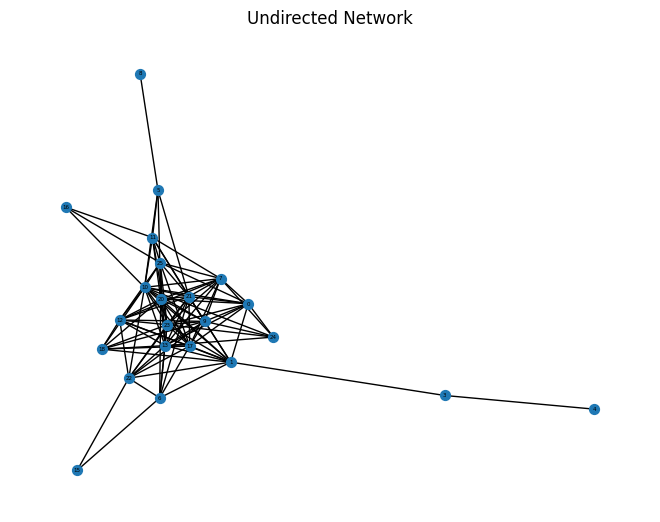

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu # we use this for binarizing a matrix

# Read the distance matrix from the CSV file
dtw_dist = np.genfromtxt(distancematrixfolder + 'distance_matrix_python.csv', delimiter=',')

# Calculate Otsu's threshold
    # this algorithm allows you to determine a boundary based on the distribution of the data
threshold_value = threshold_otsu(dtw_dist)

# Create a binary matrix using Otsu's threshold
binary_matrix = dtw_dist <= threshold_value

# Create a graph from the binary matrix
G = nx.Graph(binary_matrix)
G.remove_edges_from(nx.selfloop_edges(G)) #adjust some of the network properties (no self-loops)
# remove any non-connected units
G.remove_nodes_from(list(nx.isolates(G)))

# Draw the network
pos = nx.spring_layout(G)  # Position nodes using a spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=50, font_size=4, font_color='black')

plt.title("Undirected Network")
plt.show()

# Further analyses

From gesture networks you can further extract information about each gesture's connectivity with others. For example, we can cound the number of connections. If a gesture is connected to many other gestures it might mean that such gestures are not very disiguishable from others. So lets explore a simple conjecture: if a gesture has little connections with other, it is more distinguishable and therefore these gestures were more likely to be rated as more iconic in their meaning. We have this data from the Ortega datasat, so lets have a peak! The results seem to prove us wrong.

1. Pouw, W. , & Dixon, J. A. (2020). Gesture networks: Introducing dynamic time warping and network analysis for the kinematic study of gesture ensembles. Discourse Processes, 57(4), 301-319. doi: 10.1080/0163853X.2019.1678967

2. Pouw, W. , Dingemanse, M., Motamedi, Y., Özyürek, A. (2021). A systematic investigation of gesture kinematics in evolving manual languages in the lab. Cognitive Science. doi (open access): 10.1111/cogs.13014

3. Ortega, G., & Özyürek, A. (2020). Systematic mappings between semantic categories and types of iconic representations in the manual modality: A normed database of silent gesture. Behavior Research Methods, 52(1), 51-67.

4. Silva, D. F., Batista, G. A. E. P. A., & Keogh, E. (2016). On the effect of endpoints on dynamic time warping. SIGKDD Workshop on Mining and Learning from Time Series, II. San Francisco, USA.